## 분류 실습 : 캐글 신용카드 사기 검출

Kaggle의 신용카드 데이터 세트를 이용해 신용카드 사기 검출 분류 실습  
데이터 다운로드 : www.kaggle.com 에서 검색  
credit card fraud


**신용카드 데이터 세트 특징**
- 2013년 European Card 사용 트랜잭션을 가공해서 생성
- 불균형(Imbalanced)되어 있는 데이터 셋 284,807건의 데이터 중 492건이 Fraud(사기)

    - 레이블인 Class 속성이 매우 불균형한 분포
        - 0 값 : 정상 트랜잭선
        - 1 값 : 사기 트랜잭션 (0.172 %)


**Tip. 일반적인 사기 검출(Fraud Detection)이나 이상 검출(Anomaly Detection) 같은 데이터 세트는 레이블 값이 극도로 불균형한 분포를 이룸**  
- 사기와 같은 이상 현상은 전체 데이터에서 차지하는 비중이 매우 적기 때문


## Credit Card Fraud Detection ML 모델 구축
- 다양한 Feature Engineering 방식을 
- Logistic Regression과 LightGBM 방식을 이용하여 
- 각 방식에 적용 후 평가 비교


**Feature Engineering 주요 작업**
- 주요 Feature의 데이터 분포도 변경
    - Log 변환
- 이상치(Outlier) 제거
- SMOTE 오버 샘플링


In [47]:
import pandas as pd
import numpy as np
import seaborn as sns

#그래프 패키지 
import matplotlib.pyplot as plt 
%matplotlib inline 
# 한글 문제 해결
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')# 한글 문제 해결
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')


# 동시 출력
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [48]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./data/creditcard.csv')
card_df.head(3)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


**creditcard 피처 정보**
- Time : 데이터 생성 관련한 속성으로 분석에 큰 의미가 없음 => 삭제
- Amount : 신용카드 트랜잭션 금액
- Class : 레이블, 0-정상, 1-사기

- v1~v28 속성 : 피처 이름이 전혀 들어가 있지 않음
    * kaggle에서 칼럼 확인해보면
        - 민감한 정보를 보호하기 위해서 PCA로 압축한 속성
        
- Amount : 카드 사용액
- Class : 0은 정상 사용, 1은 부정 카드 사용


In [49]:
card_df.shape

(284807, 31)

In [50]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## 전처리 함수 :
1. 원본 유지하고 복사본을 반환
    - Time 컬럼은 삭제하고 반환

### 전처리 함수 ① : get_preprocessed_df() 작성

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
def get_preprocessed_df(df=None):
    
    df_copy = df.copy() # 원본 유지
    df_copy.drop('Time', axis=1, inplace=True)
    
    return df_copy

In [53]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1] # 피처 : 마지막 칼럼 전까지
    y_target = df_copy.iloc[:, -1] # 레이블 : 마지막 칼럼
    
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    # stratify: 타겟 값의 분포도에 맞춰, 학습과 테스트 맞춰서 분할 (레이)
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test


#### 데이터 세트 구성

In [55]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [56]:
## 학습 데이터와 테스트 데이터 레이블 분포 확인 
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)


학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


#### 예측 평가 수행 함수 (앞에서 생성)

In [57]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

#### LogisticRegression 알고리즘 학습/예측/평가

In [58]:
from sklearn.linear_model import LogisticRegression

In [59]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test,lr_pred,lr_pred_proba)

LogisticRegression()

오차 행렬
[[85281    14]
 [   61    87]]
정확도: 0.9991, 정밀도: 0.8614, 재현율: 0.5878,    F1: 0.6988, AUC:0.9594


#### 결과
- 재현율이 낮게 나왔음
    - imbalance한 데이터다 보니까 재현율 부분을 중요하게 생각하면 될 것 같음
    - 재현율이 낮아서 예측 모델로서 탐탁치 않음


**앞으로 피처 엔지니어링을 수행할 때마다 모델을 학습/예측/평가하므로 이를 위한 함수 생성**    


**`get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None)`**


In [60]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba) ## 평가진행 함수 호출

**LightGBM 학습/예측/평가.**

- (boost_from_average가 True일 경우 레이블 값이 극도로 불균형 분포를 이루는 경우 재현률 및 ROC-AUC 성능이 매우 저하됨.)  
   - LightGBM 2.1.0 이상 버전에서 이와 같은 현상 발생 
        - 디펄트가 True로 바뀜 (이전에는 False 였음)
   - True일 경우 전반적으로는 좋지만 
        - 레이블 값이 극도로 불균형 분포를 이루는 경우 재현률 및 ROC-AUC 성능이 매우 저하됨


In [61]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)

get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


### 결과
1. LogisticRegression 보다 재현율이 많이 향상됨
    - 재현율을 더 향상시킬 수있는 요소를 확인

### 중요 데이터 분포도 변환후 모델 학습/예측/평가

**중요 feature의 분포도 확인**

- **가장 중요한 속성**은 무엇일까?
    * 여러 가지 있을 수 있는데 가장 중요한 것 중 하나는 **Amount**  
        - Amount 아무래도 금액이니까 카드 금액에 따라서 실제 타겟 값에서 사기냐 정상이냐 판단하는데 가장 중요한 피처임


<Figure size 576x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x2b703eedfa0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<AxesSubplot:xlabel='Amount', ylabel='Density'>

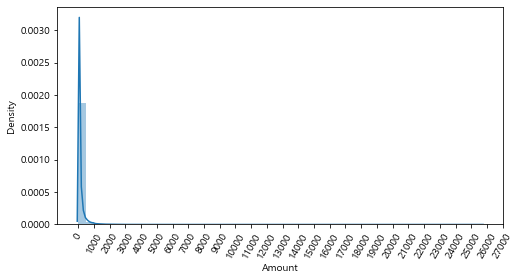

In [62]:
# 중요 속성을 Amount 선정해서 분포도 확인

import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60) # 0에서 3만까지 간격은 1000
sns.distplot(card_df['Amount'])

### 그래프 해석
- 잘 보면 대부분의 금액이 500 유로 미만인데
    - 나머지 작은 값들이 존재 25600까지 
    - 불균형하게 가지고 있음
    - 작은 값들이 길게 오른쪽으로 긴 꼬리를 가지고 있는 구조


### 전처리 함수 ② get_preprocessed_df() 수정
- StandardScaler를 이용하여 Amount 피처 변환 추가


In [16]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None) :
    df_copy = df.copy() #원본 유지
    #표준 스케일링 변환
    scaler =  StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    
    # 변환된 amount를 새로운 컬럼을 추가
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    
    # 기존 Amount 컬럼 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy


**StandardScaler 변환 후 로지스틱 회귀 및 LightGBM 학습/예측/평가**


In [64]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   61    87]]
정확도: 0.9991, 정밀도: 0.8614, 재현율: 0.5878,    F1: 0.6988, AUC:0.9594
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


**앞의 결과와 비교해서 거의 동일**
- 정규분포 변화하기 전과 별 차이가 없음

### 전처리 함수 ③ : get_processed_df( ) 수정
- 비대칭 분포를 갖는 Amount 피처를 로그 변환

In [65]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    
    # 로그변환 (np.Log1p())
    # 보통 로그변환 할때 np.Log() 보다 np.Log1p()를 사용
    amount_n = np.log1p(df_copy['Amount'])

    # Amount_Scaled 칼럼 추가
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # Amount 칼럼 삭제 (가공해서 새로운 칼럼을 만들면 기존꺼 삭제 중복해서 교육됨)
   
    
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy


---
#### log1과 exm1 설명

In [19]:
1e-1000 == 0.0
np.log(1e-1000) # -inf
np.log(1e-1000 + 1) # -inf + 1 = 0

## +1 추가해서 연산 진행하는 함수
np.log1p(1e-1000)

True

-inf

0.0

0.0

In [20]:
# Log1p() 한 값을 원래 값으로 되도릴 때 expm1() 사용 -1 QOwna

var1 = np.log1p(100)
var2 = np.expm1(var1)

var1, var2

(4.61512051684126, 100.00000000000003)

------------

<Figure size 576x288 with 0 Axes>

<AxesSubplot:xlabel='Amount_Scaled', ylabel='Density'>

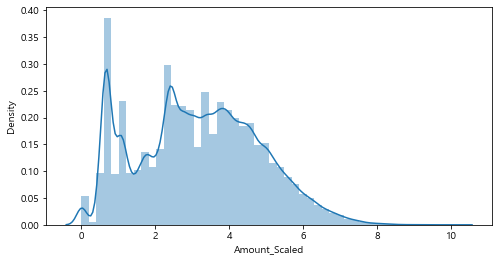

In [67]:
## 밀도함수 그래프

import seaborn as sns

card_df2 = get_preprocessed_df(card_df)
plt.figure(figsize=(8,4))
sns.distplot(card_df2['Amount_Scaled'])

In [71]:
# 학습/테스트 데이터 분리하고
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

# 예측 성능 확인
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


####  Amount를 로그 변환한 결과 
- 재현율 : 로지스틱 회귀는 변경 없고, LightGBM은 증가
- 정밀도 : 증가
- **약간씩 성능 향상**

- Amount 속성이 왜곡되어 있고, 타겟과 밀접한 연관도가 있는 중요한 칼럼이라고 가정했을 때
    - 이것들에 대해서 스큐가 높은 것을 정규분포로 풀어줘서 
    - 특히 로그 변환해서 수행 성능이 향상된 것을 확인


## 이상치 데이터 제거  후 모델 학습/예측/평가

1. 상관도가 높은 피처를 추출
2. 추출된 피처의 아웃라이어를 찾고
3. 아웃라이어를 포함하는 레코드 삭제

<Figure size 648x648 with 0 Axes>

<AxesSubplot:>

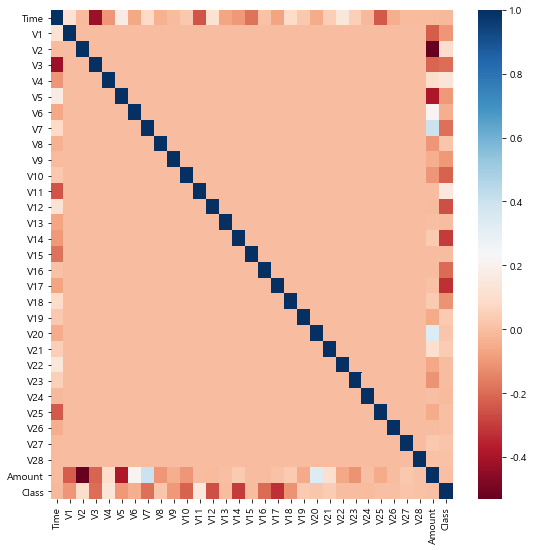

In [72]:
import seaborn as sns
plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')
## 진한 빨간/파란이면 상관관계가 존자

- 히트맵에서 cmap을 'RdBu'로 설정해
    - 양의 상관관계가 높을수록 색깔이 진한 파란색에 가깝고,
    - 음의 상관관계가 높을수록 색깔이 진한 빨강색에 가깝게 표현됨
- Class 값과 상관도가 높은 피쳐 : v12, v14, v17(짙은 빨간색)

**이 중에서 v14 아웃라이어를 찾아 제거**

**DataFrame에서 outlier에 해당하는 데이터를 필터링하기 위한 함수 생성. outlier 레코드의 index를 반환함.**

In [73]:
# 아웃라이어를 찾기 위한 함수 새로 생성

import numpy as np

# weight는 boxplot에서 이상치 계산시 1.5*IQR(몸통)을 더하고, 뺀 값들이 이상치
# 전체 데이터에서 찾지 않고 사기 데이터 (Class가 1인)에서 찾음
def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column] # column 값으로 V14 들어올 것임
    quantile_25 = np.percentile(fraud.values, 25) # 1분위수
    quantile_75 = np.percentile(fraud.values, 75) # 3분위수
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25    

    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 데이터 프레임 인덱스 찾음
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index


### v14의 밀도 그래프로 아웃라이어 확인

<Figure size 576x288 with 0 Axes>

<AxesSubplot:xlabel='V14', ylabel='Density'>

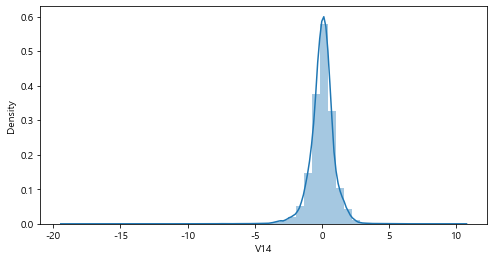

In [74]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.distplot(card_df['V14'])


In [75]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 인덱스', outlier_index)

# 8296, 8615, 9035, 9252 행 삭제

이상치 인덱스 Int64Index([8296, 8615, 9035, 9252], dtype='int64')


### 전처리 함수 ④ : get_processed_df( )
- Amount 피처 로그 변환
- V14 피처의 이상치 데이터 삭제


In [76]:
# 이상치 데이터 삭제하는 로직 추가

# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True) # axis=0 : 행 삭제
    return df_copy


In [77]:
# 학습/테스트 데이터 분리하고
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

# 예측 성능 확인
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


#### 결과  
- 로지스틱 회귀 : 재현율 많이 높아짐
- LightGBM 도 재현율 향상 
- **이상치 제거 후 로지스틱 회귀와 LightGBM 모두 예측 성능이 크게 향상됨**


## imbalanced data set 가공을 위한 언더 샘플링/오버 샘플링

- 언더 샘플링(under sampling)
    - 많은 레이블을 가진 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식  
    

- 오버 샘플링(over sampling)
    - 적은 레이블을 가진 데이터 세트를 많은 데이터 세트 수준으로 증식시키는 방식
    - 원본 데이터의 피처 값들을 약간만 변경하여 증식
    - 대표적인 방법이 SMOTE


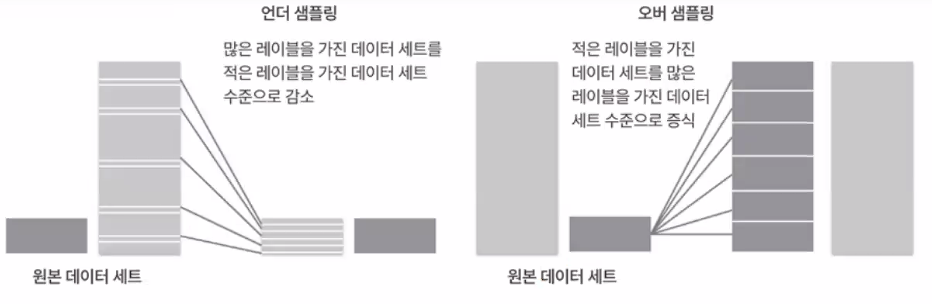

SMOTE(Synthetic Minority Over-sample Technique)
- 적은 데이터 세트에 있는 개별 데이터들의 
- K 최근접 이웃(K Nearest Neighbor)을 찾아서
- K개 이웃들과의 차이를 일정 값으로 만들어서
- 기존 데이터와 약간 차이가 나는 새로운 데이터 생성 방식


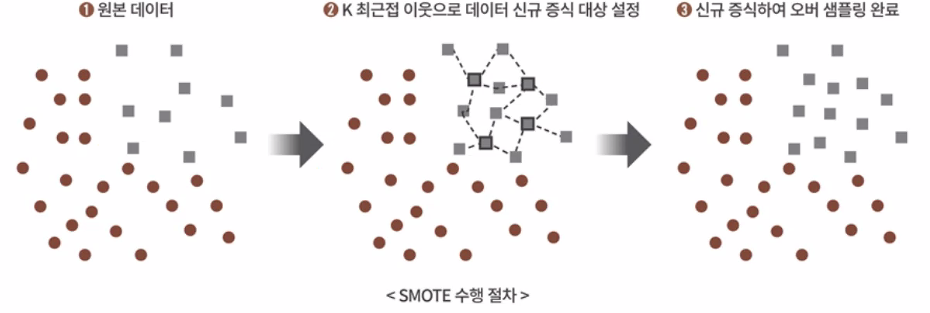

### SMOTE 방식을 제공하는 패키지
- imblearn.over_sampling (imbalanced learn)  
- imbalanced-learn 설치 필요  
    - Anaconda Prompt를 관리자 권한으로 실행시키고 설치  
    - **`conda install -c conda-forge imbalanced-learn`**  
    - 중간에 y 입력


In [78]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0) # 객체 생성
# train 데이터 세트로 들어오는 값들에 대해서  오버샘플링
# target 값 분포에 맞춰 피처값 생성(train x와 y가 인수로 전달되어야 함)
# smote.fit_resample() 사용
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)   


In [79]:
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


## 오버샘플링된 데이터로 로지스틱 회귀로 학습/예측/평가

In [80]:
# 증식된 데이터에 기반해서 다시 모델 학습/예측/평가 

lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)


오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


#### 결과
- 재현율 : 무척 좋아졌음
- 정밀도 : 엄청 떨어짐
- F1 스코어도 많이 나빠짐
- **이 모델 가지고는 실제 적용하기 힘듦 : 정밀도가 너무 낮기 때문에**


**Precision-Recall 곡선 시각화**

In [81]:
# 08_분류_모델

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()


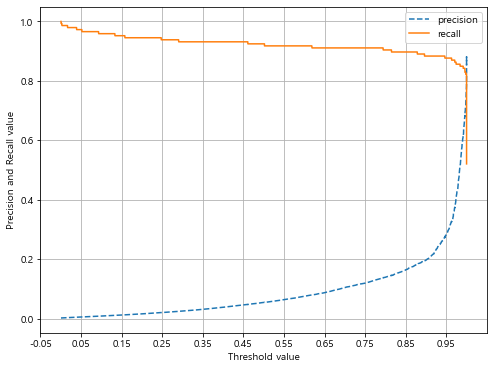

In [82]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

### 위 그래프 해석
- 재현율은 좋은데 정밀도 너무 낮은 것 확인 - 실제 적용하기 어려움
- **부적합한 모델이 될 것 같다**


## 오버샘플링된 데이터로 LightGBM

In [83]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
# 샘플링된 데이터 세트 사용
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)


오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814


### 결론

- 재현율은 약간 높아짐
- 정밀도는 떨어짐
- **정밀도를 희생시켜서 재현율을 높이는 결과로 추출되었음**
- LightGBM의 경우 정밀도를 상당한 수준으로 끌어올릴 수 있었음


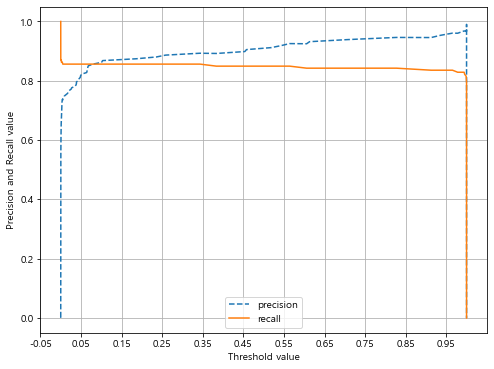

In [84]:
precision_recall_curve_plot( y_test, lgbm_clf.predict_proba(X_test)[:, 1] )